# **Model Inference**  
**A Deep Learning Approach To Automate Photo-Id Tagging Of Whales And Dolphins**

## **1. Importing the dependencies**

In [5]:
!pip install -q efficientnet
!pip install -q tensorflow_addons
!pip install tfimm

     |████████████████████████████████| 50 kB 2.9 MB/s 
     |████████████████████████████████| 1.1 MB 5.5 MB/s 
     |████████████████████████████████| 139 kB 5.4 MB/s 
     |████████████████████████████████| 462 kB 52.5 MB/s 


In [21]:
import numpy as np
import pandas as pd
import re, os, random, math
import tensorflow as tf
import efficientnet.tfkeras as efn
from sklearn import metrics
from sklearn.model_selection import KFold, train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import top_k_accuracy_score,accuracy_score,classification_report
from tensorflow.keras import backend as K
from tensorflow.keras.layers import BatchNormalization, Input, GlobalAveragePooling2D, Dropout, Dense, Softmax
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy, SparseTopKCategoricalAccuracy
from tensorflow.keras.callbacks import LearningRateScheduler, CSVLogger, ModelCheckpoint,Callback
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import tensorflow_addons as tfa
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import pickle, json
import tensorflow_hub as tfhub
from datetime import datetime
from functools import partial

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    print("Device:", tpu.master())
    strategy = tf.distribute.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.72.76.154:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.72.76.154:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Device: grpc://10.72.76.154:8470
INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Number of replicas: 8


## **2. Utility Function**

In [ ]:
AUTO = tf.data.AUTOTUNE
GCS_PATH = "gs://kds-f0a3ffcf37278c13ed2d96c571e8c6746bd2178ba7b16692dd0652c8"
BATCH_SIZE = 64
IMAGE_SIZE = [786, 786]

### 2.1. ArcFace

In [ ]:
def arcface_format(posting_id, image, label_group, matches):
    return posting_id, {'Input1': image, 'Input2': label_group}, label_group, matches

def arcface_inference_format(posting_id, image, label_group, matches):
    return image,posting_id

def arcface_eval_format(posting_id, image, label_group, matches):
    return image,label_group

### 2.2. Data Augmentation 

In [ ]:
def data_augment(posting_id, image, label_group, matches):
    ### CUTOUT
    if tf.random.uniform([])>0.5 and False:
        N_CUTOUT = 6
        for cutouts in range(N_CUTOUT):
            if tf.random.uniform([])>0.5:
               DIM = 786
               CUTOUT_LENGTH = DIM//8
               x1 = tf.cast( tf.random.uniform([],0,DIM-CUTOUT_LENGTH),tf.int32)
               x2 = tf.cast( tf.random.uniform([],0,DIM-CUTOUT_LENGTH),tf.int32)
               filter_ = tf.concat([tf.zeros((x1,CUTOUT_LENGTH)),tf.ones((CUTOUT_LENGTH,CUTOUT_LENGTH)),tf.zeros((DIM-x1-CUTOUT_LENGTH,CUTOUT_LENGTH))],axis=0)
               filter_ = tf.concat([tf.zeros((DIM,x2)),filter_,tf.zeros((DIM,DIM-x2-CUTOUT_LENGTH))],axis=1)
               cutout = tf.reshape(1-filter_,(DIM,DIM,1))
               image = cutout*image

    image = tf.image.random_flip_left_right(image)
    # image = tf.image.random_flip_up_down(image)
    image = tf.image.random_hue(image, 0.01)
    image = tf.image.random_saturation(image, 0.70, 1.30)
    image = tf.image.random_contrast(image, 0.80, 1.20)
    image = tf.image.random_brightness(image, 0.10)
    return posting_id, image, label_group, matches

# Function to decode our images
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels = 3)
    image = tf.image.resize(image, [786,786])
    image = tf.cast(image, tf.float32) / 255.0
    return image

# This function parse our images and also get the target variable
def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.int64),
#         "matches": tf.io.FixedLenFeature([], tf.string)
    }

    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    posting_id = example['image_name']
    image = decode_image(example['image'])
#     label_group = tf.one_hot(tf.cast(example['label_group'], tf.int32), depth = N_CLASSES)
    label_group = tf.cast(example['target'], tf.int32)
#     matches = example['matches']
    matches = 1
    return posting_id, image, label_group, matches

In [ ]:
train_files = np.sort(np.array(tf.io.gfile.glob(GCS_PATH + '/happywhale-2022-train*.tfrec')))

In [ ]:
valid_files = train_files[[0,5]]
train_files = train_files[[1,2,3,4,6,7,8,9]]

In [ ]:
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)
print(count_data_items(train_files),count_data_items(valid_files))

40826 10207


### 2.3. TF Records to Tensors Functions

In [ ]:
def load_dataset(filenames, ordered = False):
    """Loading Dataset from dataset: happywhale-tfrecords-v1.

    Parameters
    ----------
    label : string
            The true label of the image
    predictions : list
            A list of predicted elements (order does matter, 5 predictions allowed per image)

    Returns
    -------
    score : double
    """    
    
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False 
        
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads = AUTO)
#     dataset = dataset.cache()
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls = AUTO) 
    return dataset

# Get Dataset with some configurations for Training
def get_training_dataset(filenames):
    dataset = load_dataset(filenames, ordered = False)
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.map(arcface_format, num_parallel_calls = AUTO)
    dataset = dataset.map(lambda posting_id, image, label_group, matches: (image, label_group))
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(64)
    dataset = dataset.prefetch(AUTO)
    return dataset

# Get Dataset with some configurations for Validation
def get_val_dataset(filenames):
    dataset = load_dataset(filenames, ordered = True)
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.map(arcface_format, num_parallel_calls = AUTO)
    dataset = dataset.map(lambda posting_id, image, label_group, matches: (image, label_group))
    dataset = dataset.batch(64)
    dataset = dataset.prefetch(AUTO)
    return dataset

## **3. Model Building**

In [ ]:
# Arcmarginproduct class keras layer
class ArcMarginProduct(tf.keras.layers.Layer):
    '''
    Implements large margin arc distance.

    Reference:
        https://arxiv.org/pdf/1801.07698.pdf
        https://github.com/lyakaap/Landmark2019-1st-and-3rd-Place-Solution/
            blob/master/src/modeling/metric_learning.py
    '''
    def __init__(self, n_classes, s=30, m=0.50, easy_margin=False,
                 ls_eps=0.0, **kwargs):

        super(ArcMarginProduct, self).__init__(**kwargs)

        self.n_classes = n_classes
        self.s = s
        self.m = m
        self.ls_eps = ls_eps
        self.easy_margin = easy_margin
        self.cos_m = tf.math.cos(m)
        self.sin_m = tf.math.sin(m)
        self.th = tf.math.cos(math.pi - m)
        self.mm = tf.math.sin(math.pi - m) * m

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'n_classes': self.n_classes,
            's': self.s,
            'm': self.m,
            'ls_eps': self.ls_eps,
            'easy_margin': self.easy_margin,
        })
        return config

    def build(self, input_shape):
        super(ArcMarginProduct, self).build(input_shape[0])
        self.W = self.add_weight(
            name='W',
            shape=(int(input_shape[0][-1]), self.n_classes),
            initializer='glorot_uniform',
            dtype='float32',
            trainable=True,
            regularizer=None)

    def call(self, inputs):
        X, y = inputs
        y = tf.cast(y, dtype=tf.int32)
        cosine = tf.matmul(
            tf.math.l2_normalize(X, axis=1),
            tf.math.l2_normalize(self.W, axis=0)
        )
        sine = tf.math.sqrt(1.0 - tf.math.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = tf.where(cosine > 0, phi, cosine)
        else:
            phi = tf.where(cosine > self.th, phi, cosine - self.mm)
        one_hot = tf.cast(
            tf.one_hot(y, depth=self.n_classes),
            dtype=cosine.dtype
        )
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.n_classes

        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        return output

In [ ]:
def freeze_BN(model):
    # Unfreeze layers while leaving BatchNorm layers frozen
    for layer in model.layers:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True
        else:
            layer.trainable = False


# Create efficientnetv2-xl-21k-ft1k Model
def get_model():
    head = ArcMarginProduct
        
    with strategy.scope():
        margin = head(n_classes=15587, 
                      s=30, 
                      m=0.3, 
                      name=f'head/arcface', 
                      dtype='float32'
                     )
        inp = tf.keras.layers.Input(shape = [786, 786, 3], name = 'Input1')
        label = Input(shape=(), name='Input2')
        path = "gs://kds-63d1ff0b998a13906a20d228c6bf4a1e4100f856a5c115774b70ea8d"
        FEATURE_VECTOR = f'{path}/tfhub_models/efficientnetv2-xl-21k-ft1k/feature_vector'
        embed = tfhub.KerasLayer(FEATURE_VECTOR, trainable=True)(inp)


        embed = tf.keras.layers.Dropout(0.3)(embed)
        embed = tf.keras.layers.Dense(1024)(embed)
        x = margin([embed, label])
        
        output = tf.keras.layers.Softmax(dtype='float32')(x)
        
        model = tf.keras.models.Model(inputs = [inp, label], outputs = [output])
        embed_model = tf.keras.models.Model(inputs = inp, outputs = embed)  
        
        opt = tf.keras.optimizers.Adam(learning_rate = 0.001)

        model.compile(
            optimizer = opt,
            loss = [tf.keras.losses.SparseCategoricalCrossentropy()],
            metrics = [tf.keras.metrics.SparseCategoricalAccuracy(),tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5)]
            ) 
        
        return model,embed_model

### **3.1 Mount the Google Drive** 

In [ ]:
# First mount the Google Drive 

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Then follow the below steps to load the saved model weights.**

Step-1) **Open** the **google drive** link-
https://drive.google.com/drive/folders/1fpEAHOQhi86Y0P7NAdVYsvNI-GQWwzfq


Step-2) Once you open the google drive, then **right click** on the **highlighted project name** and **click** on the **"Add shortcut to Drive"** option, after that **click** on **"ADD SHORTCUT"** option.

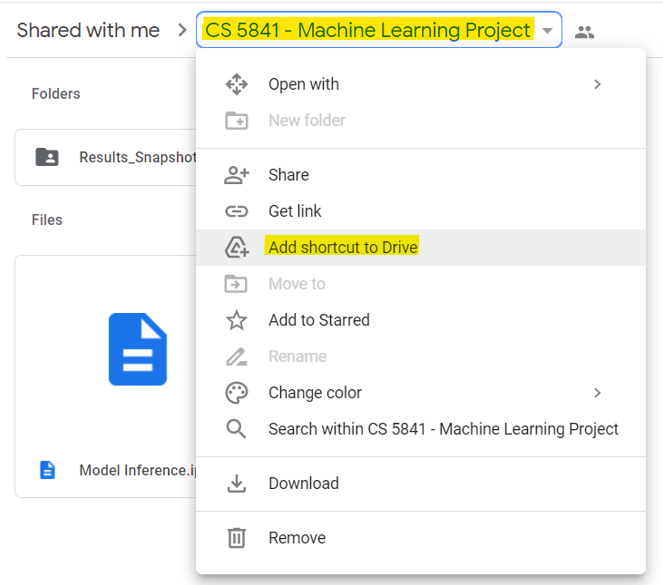

In [ ]:
# Google drive path
gdrive_path = '/content/drive/MyDrive/CS 5841 - Machine Learning Project/Stored Model & Model Weights/'

In [ ]:
train_dataset = get_training_dataset(train_files)
val_dataset = get_val_dataset(valid_files)
TRAIN_STEPS_PER_EPOCH = count_data_items(train_files)//64
VAL_STEPS_PER_EPOCH = count_data_items(valid_files)//64

In [ ]:
f = open (f'{gdrive_path}/individual_ids.json', "r")
target_encodings = json.loads(f.read())
target_encodings = {target_encodings[x]:x for x in target_encodings}

In [ ]:
with strategy.scope():
  model,embed_model = get_model()

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input1 (InputLayer)            [(None, 786, 786, 3  0           []                               
                                )]                                                                
                                                                                                  
 keras_layer (KerasLayer)       (None, 1280)         207615832   ['Input1[0][0]']                 
                                                                                                  
 dropout (Dropout)              (None, 1280)         0           ['keras_layer[0][0]']            
                                                                                                  
 dense (Dense)                  (None, 1024)         1311744     ['dropout[0][0]']            

### 3.2. Loading the trained model weights

In [ ]:
# Loading the training weight.
model.load_weights(f'{gdrive_path}/model.h5')

## **4. Model Evaluation**

### 4.1. On Training Data

In [ ]:
model.evaluate(train_dataset,steps=TRAIN_STEPS_PER_EPOCH)

637/637 [==============================] - 526s 729ms/step - loss: 0.3477 - sparse_categorical_accuracy: 0.9356 - sparse_top_k_categorical_accuracy: 0.9883


[0.3477388620376587, 0.9356357455253601, 0.9883241057395935]

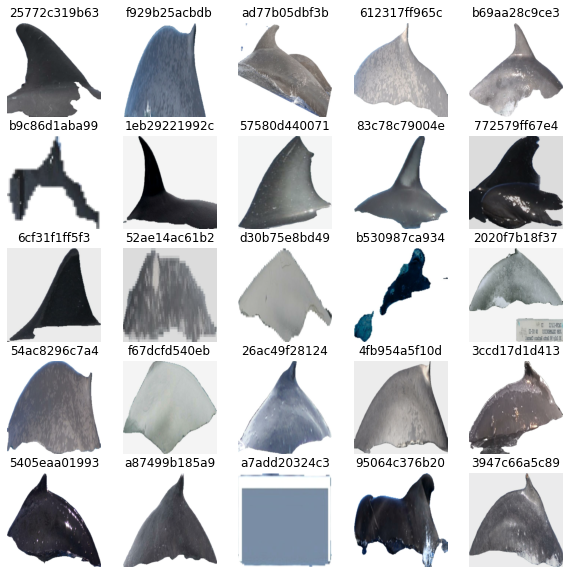

In [ ]:
image_batch, label_batch = next(iter(train_dataset))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n])
        plt.title(target_encodings[label_batch[n]])
        plt.axis("off")

show_batch(image_batch['Input1'].numpy(), label_batch.numpy());

### 4.2. On Validation Data

In [ ]:
model.evaluate(val_dataset,steps=VAL_STEPS_PER_EPOCH)

159/159 [==============================] - 96s 583ms/step - loss: 12.6755 - sparse_categorical_accuracy: 0.2386 - sparse_top_k_categorical_accuracy: 0.2931


[12.675457000732422, 0.23860062658786774, 0.293140709400177]

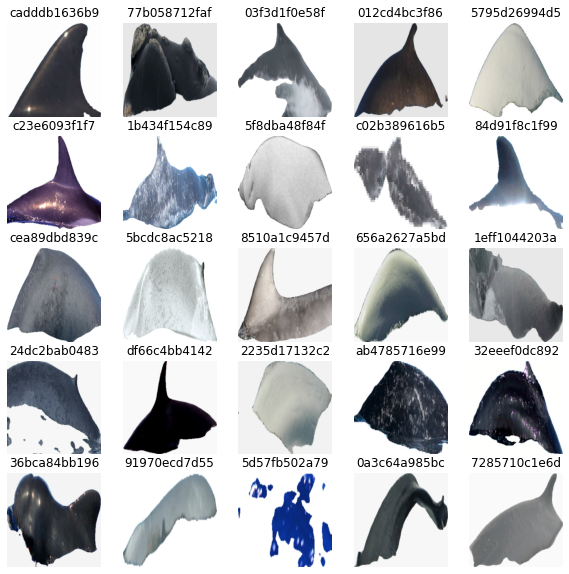

In [ ]:
image_batch, label_batch = next(iter(val_dataset))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n])
        plt.title(target_encodings[label_batch[n]])
        plt.axis("off")

show_batch(image_batch['Input1'].numpy(), label_batch.numpy())

### 4.3. Predicted accuracy on test data

In [ ]:
pred = model.predict(val_dataset,steps=160)
pred_classes = np.argmax(pred,axis=1)

val = list(val_dataset)

actual = []
for i in range(160):
  actual.extend(list(val[i][1].numpy()))

In [ ]:
# # Predicted accuracy.
accuracy_score(actual,np.argmax(pred,axis=1))

0.23954149113353582

In [ ]:
# Top 5 predicted accuracy.
top_k_accuracy_score(actual,pred,labels=range(15587),k=5)

0.2968550994415597

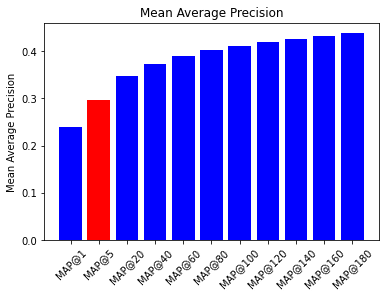

In [ ]:
# Plotting the MAP metrics for different Ks.
acc = [top_k_accuracy_score(actual,pred,labels=range(15587),k=i) for i in [1,5]+list(range(20,200,20))]

c = ['blue','red','blue','blue','blue','blue','blue','blue','blue','blue','blue']
plt.bar(['MAP@'+str(i) for i in [1,5]+list(range(20,200,20))],acc,color=c)
plt.title('Mean Average Precision')
plt.ylabel('Mean Average Precision')
plt.xticks(rotation = 45);

In [ ]:
# Comparison between species of the actual individual ids vs species of the predicted individual id.

df_train = pd.read_csv(f'{gdrive_path}/train.csv')
actual_id = [target_encodings[id] for id in actual]
actual_species = [df_train[df_train.individual_id.str.contains(id)]['species'].values[0] for id in actual_id]

pred_id = [target_encodings[id] for id in pred_classes]
pred_species = [df_train[df_train.individual_id.str.contains(id)]['species'].values[0] for id in pred_id]

print(classification_report(actual_species,pred_species))

                           precision    recall  f1-score   support

                   beluga       0.87      0.97      0.92      1489
               blue_whale       0.89      0.73      0.81       966
       bottlenose_dolphin       0.86      0.94      0.90      1956
        bottlenose_dolpin       0.59      0.69      0.64       200
             brydes_whale       0.49      0.61      0.54        31
       commersons_dolphin       0.71      0.28      0.40        18
           common_dolphin       0.69      0.86      0.76        69
     cuviers_beaked_whale       0.75      0.63      0.69        68
            dusky_dolphin       0.93      0.63      0.75       628
       false_killer_whale       0.68      0.92      0.78       665
                fin_whale       0.77      0.77      0.77       265
         frasiers_dolphin       0.00      0.00      0.00         3
                   globis       0.25      0.17      0.21        23
               gray_whale       0.81      0.89      0.85     

### 4.4. Model trainging history after each epochs

In [24]:
history = pd.read_csv(f'{gdrive_path}/history.csv')
history

,Unnamed: 0,loss,sparse_categorical_accuracy,sparse_top_k_categorical_accuracy,val_loss,val_sparse_categorical_accuracy,val_sparse_top_k_categorical_accuracy,lr
0,0,18.824900,0.000000,0.000000,18.728016,0.000000,0.000000,0.000001
1,1,17.356735,0.000000,0.000000,17.896172,0.000000,0.000000,0.000081
2,2,16.465513,0.000000,0.000025,16.987898,0.004703,0.005878,0.000160
3,3,15.524821,0.001521,0.002943,16.799156,0.008817,0.012540,0.000240
4,4,14.510433,0.004661,0.008364,16.075546,0.015382,0.023121,0.000320
5,5,12.938439,0.012534,0.021782,15.464301,0.029686,0.051141,0.000288
6,6,11.410601,0.025044,0.046286,14.826330,0.054668,0.090526,0.000259
7,7,9.971570,0.049917,0.086514,14.297588,0.079847,0.125306,0.000234
8,8,8.664656,0.082319,0.131966,13.890960,0.109141,0.156559,0.000210
9,9,7.443109,0.121664,0.184802,13.613522,0.132262,0.183502,0.000189


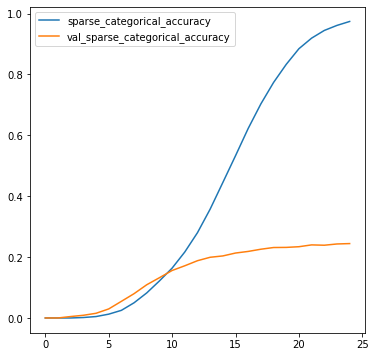

In [ ]:
history[['sparse_categorical_accuracy','val_sparse_categorical_accuracy']].plot(figsize=(6,6));

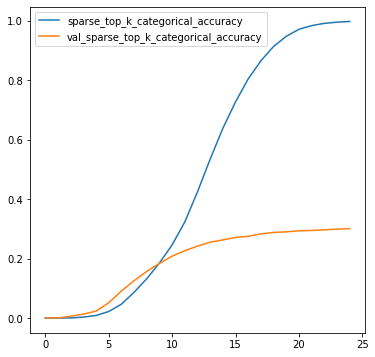

In [ ]:
history[['sparse_top_k_categorical_accuracy','val_sparse_top_k_categorical_accuracy']].plot(figsize=(6,6));

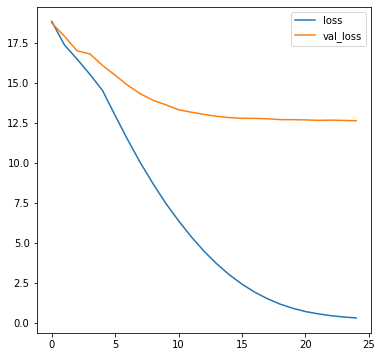

In [ ]:
history[['loss','val_loss']].plot(figsize=(6,6));